# Commandes d'import

In [4]:
# Numerical analysis module
import numpy as np
# Plot module
import matplotlib.pyplot as plt
import pandas as pd
# read netCDF files
import xarray as xr
import datetime
import openpyxl

In [5]:
infoBat = pd.DataFrame({'nEtages' : np.array([1,1,4,7,3]), \
                        'nSalles' : np.array([4,2,16,35,10]), \
                        'ville' : ["Paris","Paris","Montreuil","Paris","Paris"], \
                        'cafet' : [False, False, True, True, False], \
                        'tempMoy' : np.array([18.4, 19.0, 21.1, 19.5, 20.0])}, \
                        index = ["BatA", "PC Secu", "BatB", "BatC", "BatD"],
                        columns = ["nEtages","nSalles","ville","cafet","tempMoy"])
infoBat

,nEtages,nSalles,ville,cafet,tempMoy
BatA,1,4,Paris,False,18.4
PC Secu,1,2,Paris,False,19.0
BatB,4,16,Montreuil,True,21.1
BatC,7,35,Paris,True,19.5
BatD,3,10,Paris,False,20.0


In [7]:
date_time = pd.to_datetime(data['Time (UTC)'][1])
date_time

Timestamp('2000-06-30 22:00:00+0000', tz='UTC')

In [6]:
catExcel = pd.read_excel('./EA314_project_isolated-system.xlsx',header=2,sheet_name='Case 1',usecols='E:P')
climate_data = pd.read_excel('./EA314_project_isolated-system.xlsx',header=2,sheet_name='Case 1',usecols='T:U')
data = catExcel[1:-1]
climate = climate_data[1:-1]
#    data.iloc[:,1:-1]
climate
#data

,SOLAR_FC,WIND_FC
1,0.00,0.23
2,0.00,0.23
3,0.00,0.19
4,0.00,0.12
5,0.00,0.10
...,...,...
8731,0.38,0.35
8732,0.26,0.31
8733,0.17,0.33
8734,0.07,0.26


In [8]:
data['diesel ']

1       1.4
2       0.4
3       6.2
4       6.6
5       7.0
       ... 
8731    0.0
8732    0.0
8733    0.0
8734    0.0
8735    6.0
Name: diesel , Length: 8735, dtype: float64

# Traitement de données

In [9]:
#Generator 
solar_gen = 20  #MW
wind_gen = 20  #Mw
diesel_gen = 20 #Mw

#Storage 
charging_power = 5  #MW
Energy = 10 ##MWh

In [10]:
wind_fc= xr.DataArray(
data=climate['WIND_FC'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'Wind context data', units ='t')  
    )
solar_fc= xr.DataArray(
data=climate['SOLAR_FC'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'Radiation context data', units ='t')  
    )

load= xr.DataArray(
data=data['Load'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'Demande en MWH')  
    )
context = xr.merge([load,wind_fc,solar_fc])

In [11]:
context

<xarray.Dataset>
Dimensions:   (time: 8735)
Coordinates:
  * time      (time) datetime64[ns] 2000-06-30T22:00:00 ... 2001-06-29T20:00:00
Data variables:
    Load      (time) float64 11.0 10.0 10.0 9.0 9.0 ... 13.0 13.0 12.0 11.0 12.0
    WIND_FC   (time) float64 0.23 0.23 0.19 0.12 0.1 ... 0.31 0.33 0.26 0.24
    SOLAR_FC  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.38 0.26 0.17 0.07 0.01
Attributes:
    description:  Demande en MWH

In [12]:
solar_prod = context.Load.copy()
solar_prod = context.SOLAR_FC*solar_gen

wind_prod = context.Load.copy()
wind_prod = context.WIND_FC*wind_gen

net_load=context.Load.copy()
net_load = context.Load -solar_prod - wind_prod

missing_capacity = net_load.copy() - diesel_gen
missing_capacity.values = (abs(missing_capacity.values)+missing_capacity.values)/2



### Computing the Charging / Releasing and Stocks Data

In [24]:
missing_capacity.isel(time=slice(5,50))

<xarray.DataArray 'Missing capacity' (time: 45)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 2000-07-01T03:00:00 ... 2000-07-02T23:00:00
Attributes:
    description:  test
    units:        test

In [41]:
i=2
np.sum(missing_capacity.isel(time=slice(i+1,i+120)))

<xarray.DataArray 'Missing capacity' ()>
array(0.)

In [92]:
#Computing the charging Data
#Copy the structure 
charging = context.Load.copy()
stock = context.Load.copy()
stock.values[0]=10
charging.values[0]=0
#reseasing = context.Load.copy()
#for i in range(1,len(charging.values)):
for i in range(1,len(charging.values)):
    remain_energy = net_load.values[i]<0
    five_day_missing_cap =np.sum(missing_capacity.isel(time=slice(i+1,i+119)))
    missing_storage = five_day_missing_cap>stock.values[i-1]
    diesel_charging = np.min([five_day_missing_cap , diesel_gen-net_load.values[i] ,Energy-stock.values[i-1]])
    charging.values[i]=np.min([charging_power,remain_energy*(np.min([-net_load.values[i],Energy-stock.values[i-1]]))+
                            (1-remain_energy)*(missing_storage*0.5*(np.abs(diesel_charging)+diesel_charging))])
    stock.values[i]= stock.values[i-1] + charging.values[i]-releasing.values[i]

KeyboardInterrupt: 

In [88]:
releasing.values[0]

5.0

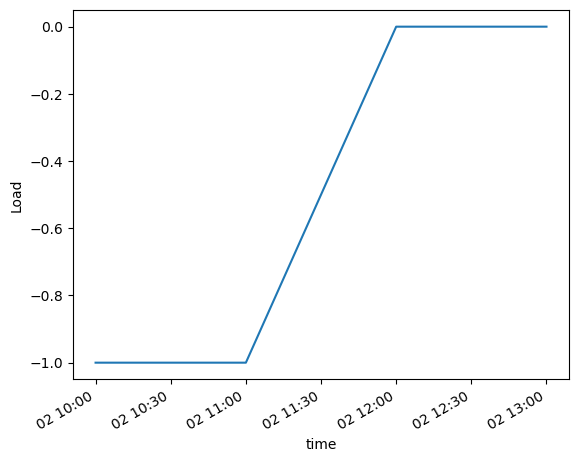

In [91]:
charging.isel(time=slice(36,40)).plot()

In [55]:

charging= xr.DataArray(
data=data['charging'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
missing_capacity= xr.DataArray(
data=data['Missing capacity'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
releasing= xr.DataArray(
data=data['releasing'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
diesel= xr.DataArray(
data=data['diesel '],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
unserved_energy= xr.DataArray(
data=data['Unserved energy'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )

unused_energy= xr.DataArray(
data=data['unused energy'],
dims = ['time'],
coords = dict(time=pd.to_datetime(data['Time (UTC)'])),attrs =dict(description = 'test', units ='test')  
    )
#t = xr.merge([load,solar,wind,net_load,charging,missing_capacity,releasing,diesel,unserved_energy,unused_energy])

In [10]:
t

<xarray.Dataset>
Dimensions:           (time: 8735)
Coordinates:
  * time              (time) datetime64[ns] 2000-06-30T22:00:00 ... 2001-06-2...
Data variables:
    Load              (time) float64 11.0 10.0 10.0 9.0 ... 13.0 12.0 11.0 12.0
    Solar             (time) float64 0.0 0.0 0.0 0.0 0.0 ... 7.6 5.2 3.4 1.4 0.2
    Wind              (time) float64 4.6 4.6 3.8 2.4 2.0 ... 7.0 6.2 6.6 5.2 4.8
    Net load          (time) float64 6.4 5.4 6.2 6.6 7.0 ... 1.6 2.0 4.4 7.0
    charging          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 1.6 0.0 0.0 0.0 0.0
    Missing capacity  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    releasing         (time) float64 5.0 5.0 0.0 0.0 0.0 ... 0.0 1.6 2.0 4.4 1.0
    diesel            (time) float64 1.4 0.4 6.2 6.6 7.0 ... 0.0 0.0 0.0 0.0 6.0
    Unserved energy   (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unused energy     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:  test
    units:        test

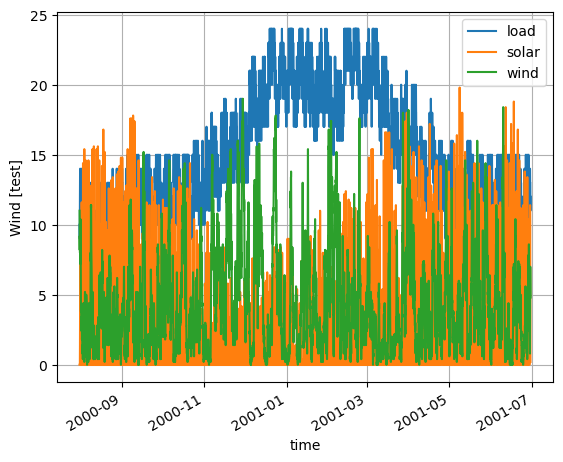

In [11]:
load.sel(time=slice('2000-08-01','2001-08-04')).plot(label='load')
solar.sel(time=slice('2000-08-01','2001-08-04')).plot(label='solar')
wind.sel(time=slice('2000-08-01','2001-08-04')).plot(label='wind')
#net_load.sel(time=slice('2000-08-01','2000-08-04')).plot(label='net_load')
plt.legend()
plt.axis()
plt.grid()